In [113]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import skrf as rf
from skrf.media import cpw

from matplotlib.collections import LineCollection
from ipywidgets import interact, widgets

%matplotlib inline
%config InlineBackend.figure_format='retina'

from quantum_electron import package_versions
package_versions()

quantum_electron 0.2.1
numpy 1.24.2
scipy 1.11.4
matplotlib 3.7.1


# Simple transmission line

We start with a simple transmission line, which has a unit cell containing an inductor $L$ in series and a capacitance $C$ to ground, see Fig.~\ref{fig:tranmission_lines}a. Following the same approach as in Section~\ref{sec:lagrangian} we write down the Lagrangian, carefully keeping track of any terms involving node $n$:
$$
    \mathcal{L} = \frac{1}{2} C \dot{\phi}_n^2 - \frac{1}{2L} \left( \phi_{n+1} - \phi_{n} \right)^2 - \frac{1}{2L} \left( \phi_{n} - \phi_{n-1} \right)^2 + \ldots
$$
The dots capture other terms that do not involve node $n$, which we can neglect due to translational symmetry of the transmission line. We further note that the capacitance $C$ and inductance $L$ are per unit cell. Therefore, if the unit cell spans a length $\Delta x$, we may write $C = C_\ell \Delta x$ and $L = L_\ell \Delta x$, where $C_\ell$ ($L_\ell$) are the capacitance and inductance per unit length, respectively.

Next, we derive the equations of motion from the Lagrange equations, which yields
$$
    C \ddot{\phi}_n + \frac{1}{L} \left( 2\phi_n - \phi_{n+1} - \phi_{n+1} \right) = 0.
$$

This yields the following matrix equation
$$
    \omega^2 C \phi_n = \frac{1}{L} \left( 2\phi_n - \phi_{n+1} - \phi_{n+1} \right), 
$$
which can also be written as $\omega^2 \vec{\phi} = [\mathbf{M}]^{-1} [\mathbf{K}] \vec{\phi}$. Therefore, we have reduced the problem to finding the eigenvalues and eigenvectors of the matrix $[\mathbf{M}]^{-1} [\mathbf{K}]$
$$
    [\mathbf{M}] = C \begin{pmatrix}
        1 & 0 & 0 &\dots \\
        0 & 1 & 0 & \dots \\
        0 & 0 & 1 & \dots \\
        \vdots & \vdots & \vdots & \ddots
    \end{pmatrix}
$$

$$
    [\mathbf{K}] = \frac{1}{L} \begin{pmatrix}
        2 & -1 & 0 &\dots \\
        -1 & 2 & -1 & \dots \\
        0 & -1 & 2 & \ddots \\
        \vdots & \vdots & \ddots & \ddots
    \end{pmatrix}
$$

In [114]:
@widgets.interact(dx_um=(1, 100, 1), total_length_mm=(0.5, 10, 0.05), L_total_nH=(1, 500, 1), C_total_fF=(1, 200, 1), quarter_λ=True)
def update(dx_um=25, total_length_mm=2, L_total_nH=100, C_total_fF=33, quarter_λ=False):
    dx = dx_um * 1e-6
    unit_cells = int(total_length_mm / (dx_um / 1e3))

    L_l = 1e-9 * L_total_nH / unit_cells
    C_l = 1e-15 * C_total_fF / unit_cells

    K = 1 / L_l * (np.diag(-1 * np.ones(unit_cells-1), k=-1) + np.diag(2 * np.ones(unit_cells), k=0) + np.diag(-1 * np.ones(unit_cells-1), k=1))

    if quarter_λ:
        K[-1, -1] = 1 / L_l
    
    M = C_l * np.diag(np.ones(unit_cells), k=0)

    ev, evecs = np.linalg.eig(np.linalg.inv(M) @ K)
    order = np.argsort(ev)

    ev_sorted = ev[order]
    evecs_sorted = evecs[:, order]

    fig, ax = plt.subplots(1, 2, figsize=(10.,3.))

    x = np.arange(unit_cells) * dx * 1e3
    for k in range(4):
        ax[0].plot(x, evecs_sorted[:, k])

    ax[0].set_xlim(-0.05, np.max(x)+0.05)
    ax[0].set_xlabel("Position along the transmission line (mm)")
    ax[0].set_ylabel(r"Phase eigenvector $\phi_n$ (a.u.)")

    lambdas = ev_sorted

    for k in range(4):
        ax[1].plot(k, np.sqrt(lambdas[k]) / (2 * np.pi * 1e9), 'o')

    m = np.arange(4)
    if quarter_λ:
        f_theory = (2 * m + 1) / (4 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15))
    else:
        f_theory = (m + 1) / (2 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15))

    ax[1].plot(m, f_theory, 's', mfc='none', mec='k', label="Continuous limit theory")
    ax[1].set_xlabel("Mode number")
    ax[1].set_ylabel("Mode frequency (GHz)")
    ax[1].set_ylim(0, 35)
    plt.legend(loc=0, frameon=False)

interactive(children=(IntSlider(value=25, description='dx_um', min=1), FloatSlider(value=2.0, description='tot…

### Scikit RF model

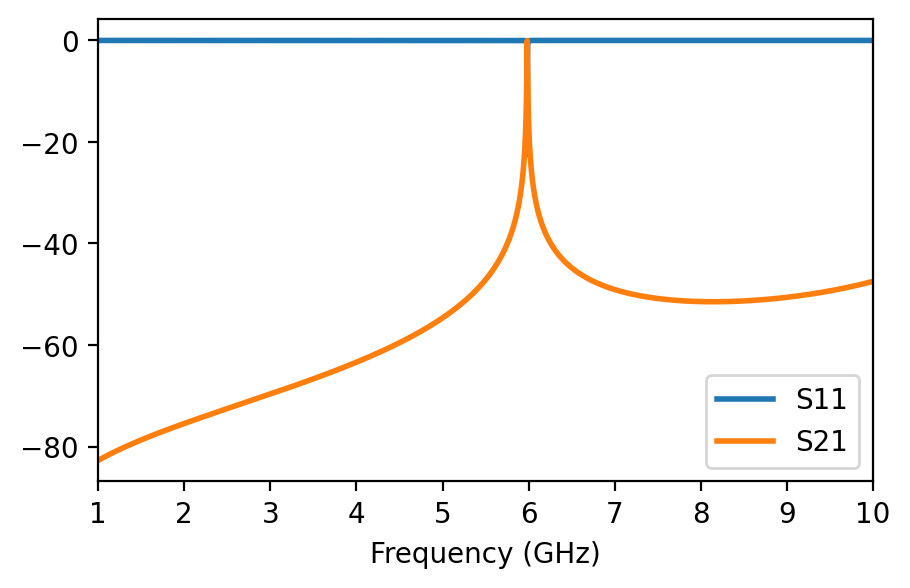

In [115]:
Z_0 = 50
l1 = 10e-3 # length of the transmission line resonator. 

# the necessary Frequency description
freq = rf.Frequency(start=1, stop=10, unit='GHz', npoints=10000)

port1 = rf.Circuit.Port(freq, 'port1', z0=Z_0)
port2 = rf.Circuit.Port(freq, 'port2', z0=Z_0)
gnd = rf.Circuit.Ground(frequency=freq, name='ground')

# Define a piece of transmission line
tline_media = cpw.CPW(freq, w=2e-6, s=10e-6, ep_r=11, rho=0)
trans_line_a = tline_media.line(l1, unit='m', name='trans_line_a')

# L and C are currently not used, but may be used for different circuits later.
C = tline_media.capacitor(1e-12, name='C')
L = tline_media.inductor(1e-9, name='L')
C_c1 = tline_media.capacitor(1e-14, name='C_in')
C_c2 = tline_media.capacitor(1e-14, name='C_out')

# Construct the network
cnx = [[(port1, 0), (C_c1, 0)],
       [(C_c1, 1), (trans_line_a, 0)],
       [(trans_line_a, 1), (C_c2, 0)],
       [(C_c2, 1), (port2, 0)]]

cir = rf.Circuit(cnx)
ntw = cir.network

# Plot the transmission
plt.figure(figsize=(5.,3.))
ntw.plot_s_db(m=0, n=0, lw=2, logx=False)
ntw.plot_s_db(m=1, n=0, lw=2, logx=False)

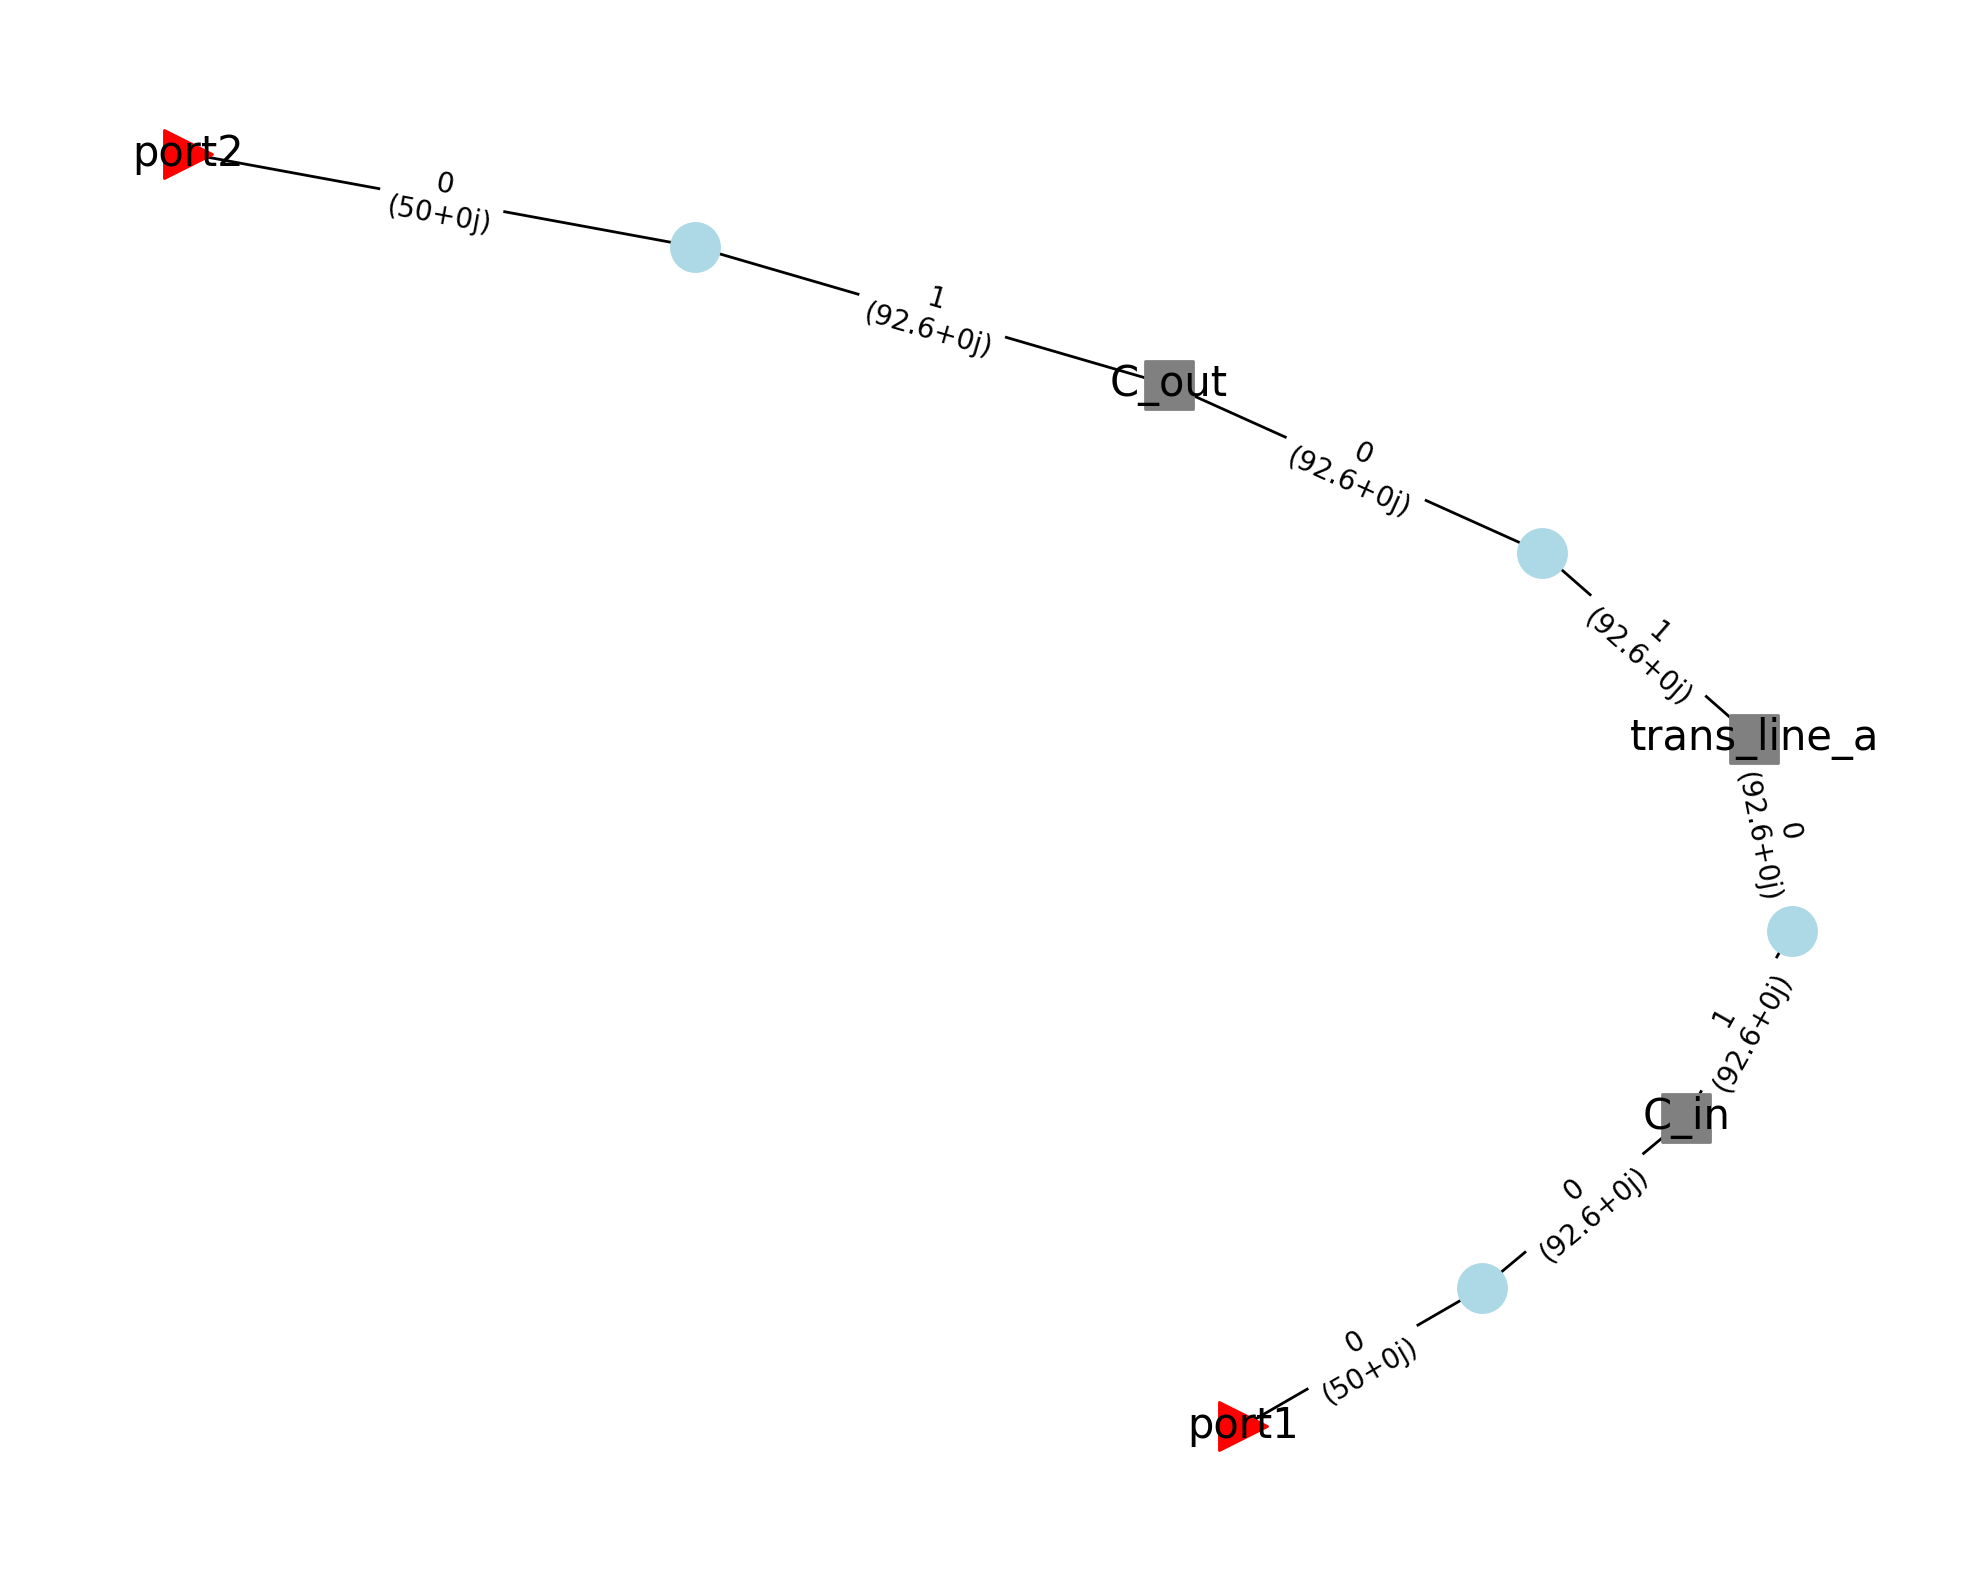

In [5]:
cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_labels=True, edge_fontsize=10)

# Transmission line with shunt capacitance

We now study the effect of a shunt capacitor on the transmission line resonator properties. The unit cell is still similar to the simple transmission line. However, including shunt capacitors adds extra terms involving $C_s$ to the Lagrangian:
$$
    \mathcal{L} = \frac{1}{2} C \dot{\phi}_n^2 + \frac{1}{2} C_s \left( \dot{\phi}_{n+1} - \dot{\phi}_{n}  \right)^2 
    + \frac{1}{2} C_s \left( \dot{\phi}_{n} - \dot{\phi}_{n-1}  \right)^2 - \frac{1}{2L} \left( \phi_{n+1} - \phi_{n} \right)^2  
    - \frac{1}{2L} \left( \phi_{n} - \phi_{n-1} \right)^2 + \ldots
$$

This results in the following equations of motion:
$$
    C \ddot{\phi}_n + C_s \left( 2 \ddot{\phi}_n  - \ddot{\phi}_{n+1} - \ddot{\phi}_{n-1} \right) 
    + \frac{1}{L} \left( 2\phi_n - \phi_{n+1} - \phi_{n+1} \right) = 0.
$$

To solve these equations numerically, we can write down the equivalent of Eq.~\eqref{eq:simple_tl_matrix_eq}:
$$ 
    \omega^2 \left [ (C + 2C_s) \phi_n - C_s \phi_{n+1} - C_s \phi_{n-1} \right] = 
    \frac{1}{L} \left( 2\phi_n - \phi_{n+1} - \phi_{n+1} \right), 
$$
Or written in matrix form:
$$
    [\mathbf{M}] = \begin{pmatrix}
        C + 2C_s & -C_s & 0 &\dots \\
        -C_s & C + 2C_s & -C_s & \dots \\
        0 & -C_s & C + 2C_s & \ddots \\
        \vdots & \vdots & \ddots & \ddots
    \end{pmatrix}
$$

$$
    [\mathbf{K}] = \frac{1}{L} \begin{pmatrix}
        2 & -1 & 0 &\dots \\
        -1 & 2 & -1 & \dots \\
        0 & -1 & 2 & \ddots \\
        \vdots & \vdots & \ddots & \ddots
    \end{pmatrix}
$$

In [6]:
@widgets.interact(dx_um=(1, 100, 1), total_length_mm=(0.5, 10, 0.05), L_total_nH=(1, 500, 1), C_total_fF=(1, 200, 1), shunt_cap_fraction=(0, 4, 0.01), quarter_λ=False)
def update(dx_um=25, total_length_mm=2, L_total_nH=100, C_total_fF=33, shunt_cap_fraction=0.01, quarter_λ=False):
    dx = dx_um * 1e-6
    unit_cells = int(total_length_mm / (dx_um / 1e3))

    L_l = 1e-9 * L_total_nH / unit_cells
    C_l = 1e-15 * C_total_fF / unit_cells
    C_s = C_l * shunt_cap_fraction

    K = np.diag(-1/L_l * np.ones(unit_cells-1), k=-1) + np.diag(2/L_l * np.ones(unit_cells), k=0) + np.diag(-1/L_l * np.ones(unit_cells-1), k=1)
    M = np.diag(-C_s * np.ones(unit_cells-1), k=-1) + np.diag((C_l + 2 * C_s) * np.ones(unit_cells), k=0) + np.diag(-C_s * np.ones(unit_cells-1), k=1)

    if quarter_λ:
        K[-1, -1] = 1 / L_l

    ev, evecs = np.linalg.eig(np.linalg.inv(M) @ K)
    order = np.argsort(ev)

    ev_sorted = ev[order]
    evecs_sorted = evecs[:, order]

    print(1/(2 * unit_cells * dx * 1e9) * 1/ np.sqrt(L_l * C_l / dx / dx))

    fig, ax = plt.subplots(1, 2, figsize=(10.,3.))
    
    x = np.arange(unit_cells) * dx * 1e3
    for k in range(4):
        ax[0].plot(x, evecs_sorted[:, k])

    ax[0].set_xlim(-0.05, np.max(x)+0.05)
    ax[0].set_xlabel("Position along the transmission line (mm)")
    ax[0].set_ylabel(r"Phase eigenvector $\phi_n$ (a.u.)")

    for k in range(20):
        if k <= 4:
            ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o')
        else:
            ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o', color='lightgray')

    # Dispersion with shunt capacitance:
    m = np.arange(7)
    if quarter_λ:
        f_with_shunt = (2 * m + 1) / (4 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15)) * np.sqrt(1 / (1 + (m * np.pi / unit_cells) ** 2 * C_s / C_l))
        f_wo_shunt = (2 * m + 1) / (4 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15))
    else:
        f_with_shunt = (m + 1) / (2 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15)) * np.sqrt(1 / (1 + (m * np.pi / unit_cells) ** 2 * C_s / C_l))
        f_wo_shunt = (m + 1) / (2 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15))

    ax[1].plot(m, f_wo_shunt, 's', mfc='none', mec='k', label="Theory without shunt")
    ax[1].plot(m, f_with_shunt, 'd', mfc='none', mec='k', label="Theory with shunt")

    ax[1].set_xlabel("Mode number")
    ax[1].set_ylabel("Mode frequency (GHz)")
    ax[1].set_ylim(0, 35)
    plt.legend(loc=4, frameon=False)



interactive(children=(IntSlider(value=25, description='dx_um', min=1), FloatSlider(value=2.0, description='tot…

# Meandering resonator with shunt capacitances

Having laid the basis with a simple transmission line and a shunted transmission line, we now move to the most accurate model of a meandering resonator. Using this model, we can study the effect of shunt capacitance between the meanders.

We start with the relevant terms in the Lagrangian of the unit cell, which involves nodes $n$ and $n+1$:
$$
    \mathcal{L} = \frac{1}{2} C \dot{\phi}_n^2
    + \frac{1}{2} C_s \left( \dot{\phi}_{n+1} - \dot{\phi}_{n-1}  \right)^2 + \frac{1}{2} C_s \left( \dot{\phi}_{n+3} - \dot{\phi}_{n+1}  \right)^2  
    - \frac{1}{2L} \left( \phi_{n+1} - \phi_{n} \right)^2 - \frac{1}{2L} \left( \phi_{n+2} - \phi_{n+1} \right)^2 + \ldots
$$
This yields two separate equations of motion for $\phi_n$ and $\phi_{n+1}$, because the structure is translationally invariant every two unit cells.
$$
    C \ddot{\phi}_n + \frac{1}{L} \left( 2\phi_n - \phi_{n+1} - \phi_{n+1} \right) = 0
$$ 
and 
$$
    C_s \left( 2 \ddot{\phi}_{n+1} - \ddot{\phi}_{n-1} - \ddot{\phi}_{n+3} \right) + \frac{1}{L} \left( 2 \phi_{n+1} - \phi_{n} - \phi_{n+2} \right) = 0
$$
The corresponding matrices are
\begin{align}
    [\mathbf{M}] = \begin{pmatrix}
        C & 0    & 0     & 0     & 0     & 0     & 0 & \dots \\
        0 & 2C_s  & 0     & -C_s  & 0 & 0 & 0 & \dots \\
        0 & 0    & C     & 0     & 0     & 0     & 0 & \ddots \\
        0 & -C_s    & 0     & 2C_s  & 0     & -C_s  & 0 & \ddots \\  
        \vdots & \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & \ddots
    \end{pmatrix}
\end{align}

\begin{align}
    [\mathbf{K}] = \frac{1}{L} \begin{pmatrix}
        2 & -1 & 0 &\dots \\
        -1 & 2 & -1 & \dots \\
        0 & -1 & 2 & \ddots \\
        \vdots & \vdots & \ddots & \ddots
    \end{pmatrix}
\end{align}
Note that every meander has two separate equations, and therefore the dimensions of $[\mathbf{K}]$ and $[\mathbf{M}]$ are $2N \times 2N$ where each segment is $N$ are the number of segments in the transmission line. 


In [116]:
@widgets.interact(L_per_meander_nH=(1, 25, 1), Cg_per_meander_fF=(0.1, 10, 0.01), meanders=(10, 20, 1), shunt_cap_fraction=(0.01, 4, 0.01))
def update(L_per_meander_nH=5, Cg_per_meander_fF=1.4, meanders=16, shunt_cap_fraction=0.5):
    L_l = L_per_meander_nH * 1e-9
    C_g = Cg_per_meander_fF * 1e-15
    C_s = C_g * shunt_cap_fraction
    dx = 75e-6 

    K = np.diag(-1/L_l * np.ones(2 * meanders -1), k=-1) + np.diag(2/L_l * np.ones(2 * meanders), k=0) + np.diag(-1/L_l * np.ones(2 * meanders-1), k=1)

    diag_0 = np.zeros(2 * meanders)
    diag_0[::2] = C_g
    diag_0[1::2] = 2 * C_s

    diag_plus_2 = np.zeros(2 * meanders - 2)
    diag_plus_2[1::2] = -C_s
    diag_minus_2 = np.zeros(2 * meanders - 2)
    diag_minus_2[1::2] = -C_s

    M = np.diag(diag_0, k=0) + np.diag(diag_plus_2, k=2) + np.diag(diag_minus_2, k=-2)

    ev, evecs = np.linalg.eig(np.linalg.inv(M) @ K)
    order = np.argsort(ev)

    ev_sorted = ev[order]
    evecs_sorted = evecs[:, order]

    print("Theory, without shunt: ", 1/(2 * meanders * dx * 1e9) * 1/ np.sqrt(2 * L_l * C_g / dx / dx))

    fig, ax = plt.subplots(1, 2, figsize=(10.,3.))
    
    x = np.arange(2 * meanders) * dx * 1e3
    for k in range(5):
        ax[0].plot(x, evecs_sorted[:, k])

    ax[0].set_xlim(-0.05, np.max(x)+0.05)
    ax[0].set_xlabel("Position along the transmission line (mm)")
    ax[0].set_ylabel(r"Phase eigenvector $\phi_n$ (a.u.)")

    for k in range(20):
        if k <= 4:
            ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o')
        else:
            ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o', color='lightgray')

    print("Simulated, with shunt: ", np.sqrt(ev_sorted[0]) / (2 * np.pi * 1e9))

    # Dispersion with shunt capacitance:
    m = np.arange(1, 8)
    f_with_shunt = m / (2 * 1e9) * np.sqrt(1 / (meanders * 2 * L_l * meanders * C_g)) * np.sqrt(1 / (1 + (m * np.pi / meanders) ** 2 * C_s / C_g))
    f_wo_shunt = m / (2 * 1e9) * np.sqrt(1 / (meanders * 2 * L_l * meanders * C_g)) 

    ax[1].plot(np.arange(7), f_wo_shunt, 's', mfc='none', mec='k', label="Theory without shunt")
    ax[1].plot(np.arange(7), f_with_shunt, 'd', mfc='none', mec='k', label="Theory with shunt")

    ax[1].set_xlabel("Mode number")
    ax[1].set_ylabel("Mode frequency (GHz)")
    ax[1].set_ylim(0, 35)
    plt.legend(loc=4, frameon=False)


interactive(children=(IntSlider(value=5, description='L_per_meander_nH', max=25, min=1), FloatSlider(value=1.4…

# Periodic transmission line with a break

In [117]:
def plot_mode_profile(eigenvectors, eigenvalues, colorbar_label=r"Phase eigenvector $\phi$ (x)", clim=None, savepath=None):
    """Plots the eigenvectors of the folded transmission line circuit. 

    Args:
        eigenvectors (ArrayLike): 2D array such that eigenvectors[0] is the first eigenvector, etc.
        eigenvalues (ArrayLike): 1D array. The n-th eigenvalue should correspond to the n-th eigenvector.
        colorbar_label (regexp, optional): Defaults to r"Phase eigenvector $\phi$ (x)".
        savepath (_type_, optional): Save path for the figure. Defaults to None, in which case nothing is saved.
    """
    n = 6
    fig, ax = plt.subplots(2, 3, figsize=(12, 6))
    ax = ax.flatten()
    for k in range(n):
        num_segments = len(eigenvectors[k])
        # eigenvector = eigenvector[num_segments//2 : -num_segments // 2]

        gap = 0.02
        theta_start = np.linspace((-1 + gap) * np.pi, (1 - gap) * np.pi, num_segments+1)[:-1]
        theta_end = np.linspace((-1 + gap) * np.pi, (1 - gap) * np.pi, num_segments+1)[1:]
        thetas = np.zeros(2*num_segments)
        thetas[::2] = theta_start
        thetas[1::2] = theta_end

        r = 1.00 

        arcs = [np.column_stack([r * np.cos(thetas[2*k:2*k+2]), r * np.sin(thetas[2*k:2*k+2])]) for k in range(len(thetas)//2)]

        # set axes limits manually because Collections do not take part in autoscaling
        ax[k].set_xlim(-1.1, 1.1)
        ax[k].set_ylim(-1.1, 1.1)
        ax[k].set_aspect("equal")  # to make the arcs look circular

        if clim is not None: 
            vmin, vmax = clim
        else:
            vmin = -np.abs(eigenvectors[k]).max()
            vmax = np.abs(eigenvectors[k]).max()

        # create a LineCollection with the half-circles and color mapping
        line_collection = LineCollection(arcs, array=np.roll(eigenvectors[k], num_segments // 2 + 1), cmap=plt.cm.RdBu_r, linewidth=6, 
                                         norm=plt.Normalize(vmin=vmin, vmax=vmax))
        ax[k].add_collection(line_collection)

        cbar = fig.colorbar(line_collection, ax=ax[k], label=colorbar_label, fraction=0.040, pad=0.03, format="%.0e")
        ax[k].set_title(f"f = {np.sqrt(eigenvalues[k]) / (2 * np.pi * 1e9):.2f} GHz")
        ax[k].axis('off')

    if savepath is not None: 
        fig.savefig(savepath, bbox_inches='tight', pad_inches=0.05)

## EOM solution in the $q$ basis

By starting in the charge basis, it is easier to add the electron-resonator coupling term to the Lagrangian.

\begin{align}
    \mathcal{L} &= \frac{L}{2} \sum_{n = 1}^N (\dot{q}_n^2 + \dot{q}_{-n}^2) \notag \\
    &- \frac{1}{2C} \sum_{n=1}^N \left[ \left( q_{n+1} - q_n \right)^2 + \left( q_{-n-1} -q_{-n} \right)^2 \right] \\
    &-\frac{q_0^2}{2C_\mathrm{dot}} - \frac{1}{2C} \left[ (q_1 - q_0)^2 + (q_{-1} - q_0)^2 \right].
    
\end{align}

Using shorthand notation for the dot capacitance $\alpha = C_\mathrm{dot}/ (C + 2C_\mathrm{dot})$, the matrices become
\begin{align}
    [\mathbf{M}] = L \mathbb{I}, 
\end{align}
where  $\mathbb{I}$ is the identity matrix, and 
\begin{align}
    [\mathbf{K}] = \frac{1}{C} \begin{pmatrix}
        2 & -1    & 0     & 0     & 0     & 0     & \dots & -1 \\
        -1 & 2  & -1     & 0  & 0 & 0 & \dots & 0 \\
         & \ddots & \ddots & \ddots &  &   &  \\
        0 &   0  & -1     & 2 - \alpha     & -\alpha     &  0  & 0& \ldots \\
        0 &   0  & 0 & -\alpha     & 2 - \alpha  & -1     & 0  & \ldots \\  
        \vdots & \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & \ddots \\
        0 &   0  & 0     & 0     & 0     &  -1  & 2& -1 \\
        -1 &   0  & 0     & 0     & 0     &  0  & -1 & 2 \\
    \end{pmatrix}
\end{align}
Note that we have additionally implemented periodic boundary condition through the non-zero matrix elements for $[\mathbf{K}]_{-N, N}$ and $[\mathbf{K}]_{N, -N}$. The eigenvectors of $[\mathbf{M}]^{-1} [\mathbf{K}]$ are the charge distribution across the resonator.

In [118]:
def make_network(dx_um=25, total_length_mm=2, C_dot_fF=0.1, L_total_nH=100, C_total_fF=33, plot=True, return_all=False):
    """Calculates the eigenfrequencies of the folded transmission line resonator circuit in the charge basis.

    Args:
        dx_um (int, optional): Unit cell length in microns. Defaults to 25.
        total_length_mm (int, optional): Total length of the transmission line (This only determines the number of unit cells). Defaults to 2.
        C_dot_fF (float, optional): Dot capacitance in fF. Defaults to 0.1.
        L_total_nH (int, optional): Total inductance of the circuit in nH. Defaults to 100.
        C_total_fF (int, optional): Total capacitance of the transmission line in fF. Defaults to 33.
        plot (bool, optional): if true, it plots the eigenmodes and eigenfrequencies. Defaults to True.
        return_all (bool, optional): if true, it returns the eigenfrequencies, modes and voltage across the capacitor. Defaults to False.

    Returns:
        Tuple: Eigenvector (sorted by ascending eigenfrequency), Eigenfrequencies (sorted by ascending eigenfrequency), Voltage across the capacitor
    """
    dx = dx_um * 1e-6
    unit_cells = int(total_length_mm / (dx_um / 1e3))

    if unit_cells % 2:
        unit_cells += 1

    assert not(unit_cells % 2)
    L_l = L_total_nH * 1e-9 / unit_cells
    C_l = C_total_fF * 1e-15 / unit_cells
    C_dot = C_dot_fF * 1e-15

    K = np.diag(-1 * np.ones(unit_cells-1), k=-1) + np.diag(2 * np.ones(unit_cells), k=0) + np.diag(-1 * np.ones(unit_cells-1), k=1)
    M = L_l * C_l * np.diag(np.ones(unit_cells), k=0)

    alpha = C_dot / (C_l + 2 * C_dot)

    idx_minus1 = unit_cells // 2 - 1
    idx_plus1 = unit_cells // 2 + 1

    K[idx_minus1:idx_plus1, idx_minus1:idx_plus1] = np.array([[2 - alpha, -alpha], 
                                                              [-alpha, 2 - alpha]])

    # Periodic boundary conditions
    K[0, -1] = -1
    K[-1, 0] = -1

    ev, evecs = np.linalg.eig(np.linalg.inv(M) @ K)
    order = np.argsort(ev)

    ev_sorted = ev[order]
    evecs_sorted = evecs[:, order]

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(10.,3.))
    
    deltaVs = list()
    for k in range(6):
        # Shifted eigenvector
        evec_shifted = np.roll(evecs_sorted[:, k], unit_cells // 2)

        # Determine the voltage across the capacitor
        q0 = alpha * (evec_shifted[0] + evec_shifted[-1])
        deltaVs.append(q0 / C_dot)

        # Figure out what is the charge across the center capacitor
        evec_shifted = np.insert(evec_shifted, 0, q0)
        
        x = np.arange(unit_cells + 1) * dx * 1e3
        if plot:
            ax[0].plot(x, evec_shifted)

    if plot:
        ax[0].set_xlim(-0.05, np.max(x)+0.05)
        ax[0].set_xlabel("Position along the transmission line (mm)")
        ax[0].set_ylabel(r"Charge eigenvector $q_n$ (a.u.)")

        for k in range(20):
            ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o')

        m = np.arange(7)
        f_no_dot = (m + 1)/(2*total_length_mm * 1e-3 * 1e9) * 1 / np.sqrt(L_l * (C_l + C_dot/unit_cells) / dx / dx)
        ax[1].plot(m, f_no_dot, 'd', mfc='none', mec='k', label="Theory without dot")

        ax[1].set_xlabel("Mode number")
        ax[1].set_ylabel("Mode frequency (GHz)")
        ax[1].set_ylim(0, 30)
        
        plot_mode_profile(evecs_sorted.T, ev_sorted, colorbar_label="Charge eigenvector $q$ (x)")

    if return_all:
        return evecs_sorted, ev_sorted, deltaVs

In [120]:
@widgets.interact(dx_um=(1, 100, 1), total_length_mm=(0.5, 10, 0.05), C_dot_fF=(0.0, 100, 0.1), L_total_nH=(1, 500, 1), C_total_fF=(1, 200, 1))
def update(dx_um=25, total_length_mm=2, C_dot_fF=0.1, L_total_nH=200, C_total_fF=33):
    make_network(dx_um=dx_um, total_length_mm=total_length_mm, C_dot_fF=C_dot_fF, 
                 L_total_nH=L_total_nH, C_total_fF=C_total_fF, plot=True, return_all=False)

interactive(children=(IntSlider(value=25, description='dx_um', min=1), FloatSlider(value=2.0, description='tot…

### Sweeping $C_\mathrm{dot}$

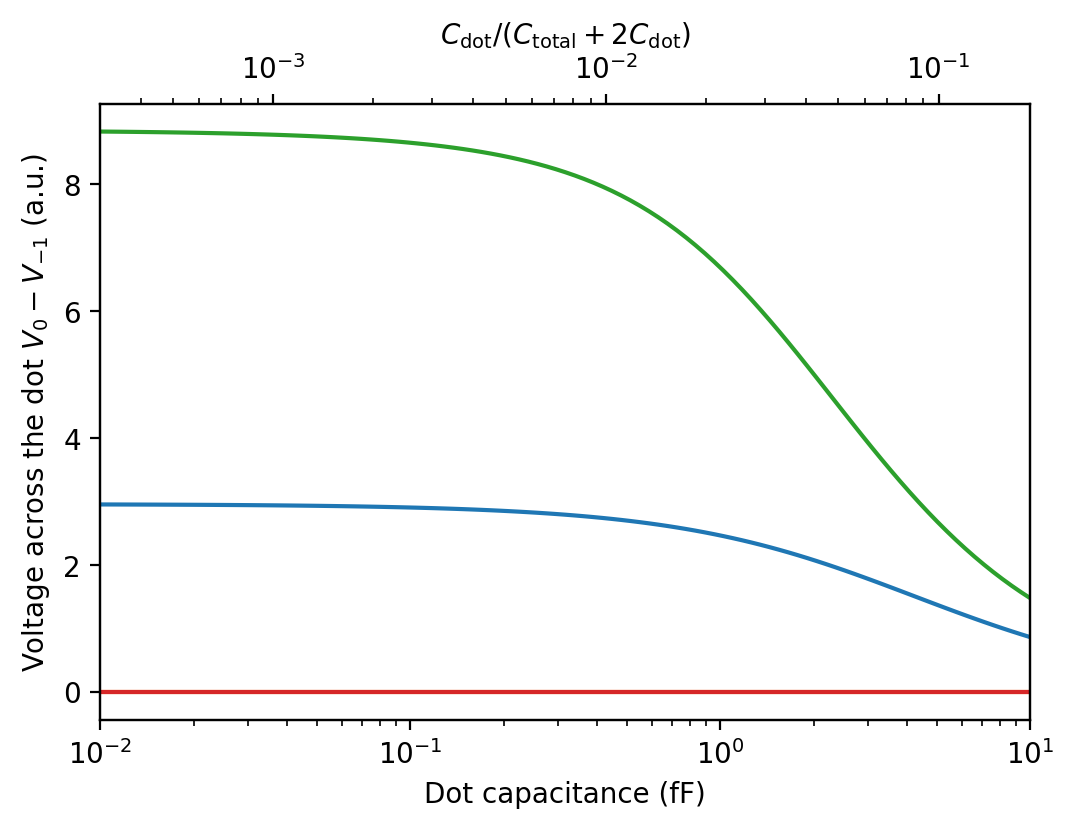

In [121]:
dx_um=25
total_length_mm=2
dot_capacitances_fF = np.logspace(-2, 1, 101)

do_plot = False
deltaV = np.zeros((len(dot_capacitances_fF), 6))
eigenfreqs = np.zeros((len(dot_capacitances_fF), 6))

fig = plt.figure(figsize=(6.,4.))

for L_total_nH, C_total_fF in zip([200], [33]):
    for m, C_dot_fF in enumerate(dot_capacitances_fF):  

        evecs_sorted, ev_sorted, dV = make_network(dx_um=dx_um, total_length_mm=total_length_mm, C_dot_fF=C_dot_fF, 
                                                L_total_nH=L_total_nH, C_total_fF=C_total_fF, plot=False, return_all=True)
        

        deltaV[m, :] = np.abs(np.array(dV))
        eigenfreqs[m, :] = np.sqrt(ev_sorted[:6]) / (2 * np.pi * 1e9)

    for k in range(4):
        plt.plot(dot_capacitances_fF, deltaV[:, k] / 1e13)
    plt.xlabel("Dot capacitance (fF)")
    plt.ylabel("Voltage across the dot $V_0 - V_{-1}$ (a.u.)")
    plt.xlim(dot_capacitances_fF.min(), dot_capacitances_fF.max())
    plt.xscale('log')

    ax1 = plt.gca()
    ax2 = ax1.twiny()
    ax2.set_xscale('log')
    xmin, xmax = ax1.get_xlim()
    ax2.set_xlim(xmin / (C_total_fF + 2*xmin), xmax / (C_total_fF + 2*xmax))
    ax2.set_xlabel("$C_\mathrm{dot} / (C_\mathrm{total} + 2 C_\mathrm{dot})$")

Text(0.5, 0, '$C_\\mathrm{dot} / (C_\\mathrm{total} + 2 C_\\mathrm{dot})$')

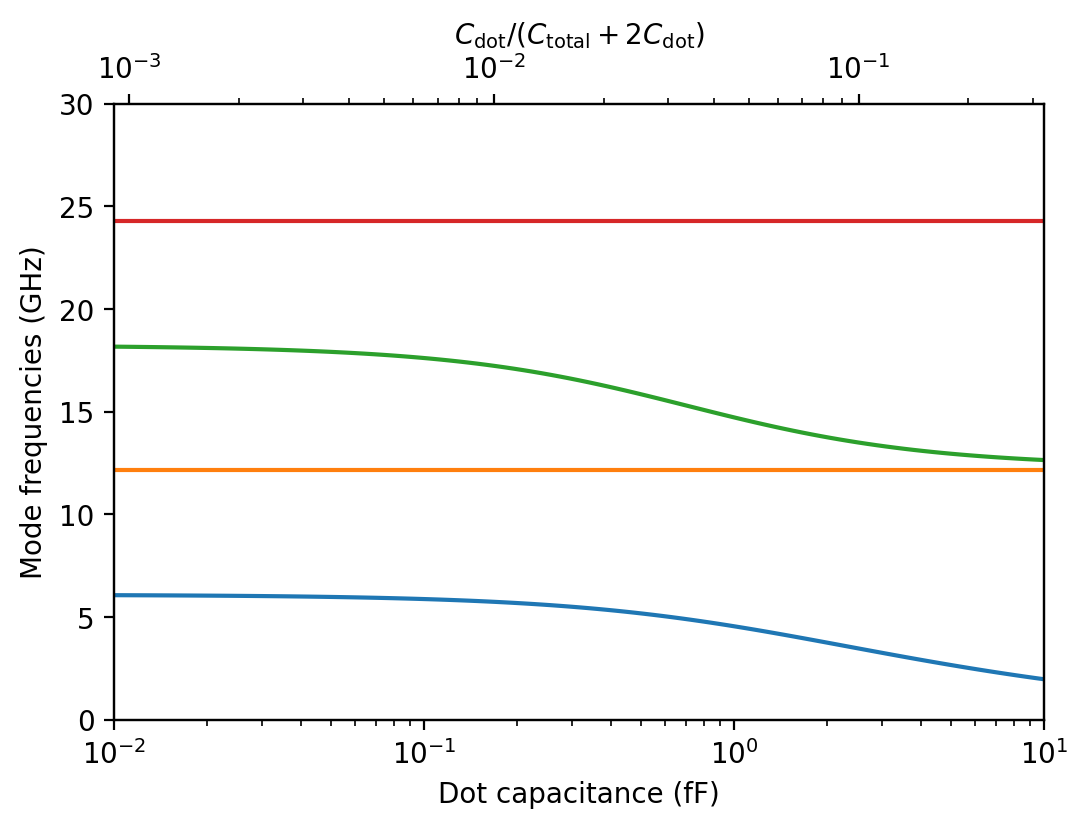

In [97]:
fig = plt.figure(figsize=(6., 4.))
for k in range(4):
    plt.plot(dot_capacitances_fF, eigenfreqs[:, k])
plt.xlabel("Dot capacitance (fF)")
plt.ylabel("Mode frequencies (GHz)")
plt.ylim(0, 30)
plt.xlim(dot_capacitances_fF.min(), dot_capacitances_fF.max())
plt.xscale('log')

ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xscale('log')
xmin, xmax = ax1.get_xlim()
ax2.set_xlim(xmin / (C_total_fF + 2*xmin), xmax / (C_total_fF + 2*xmax))
ax2.set_xlabel("$C_\mathrm{dot} / (C_\mathrm{total} + 2 C_\mathrm{dot})$")

### Sweeping $Z_\mathrm{res}$

Here we'll keep the resonance frequency fixed, and find the total inductance and capacitance such that we sweep the resonator impedance linearly.
We'll use the following relations:

$$
\omega_0 = \frac{1}{\sqrt{L(C + 2C_\mathrm{dot})}} \\
Z = \sqrt{\frac{L}{C + 2C_\mathrm{dot}}}
$$
such that $L = Z / \omega_0$ and $C = 1 / \omega_0 Z - 2C_\mathrm{dot}$

(100.0, 10000.0)

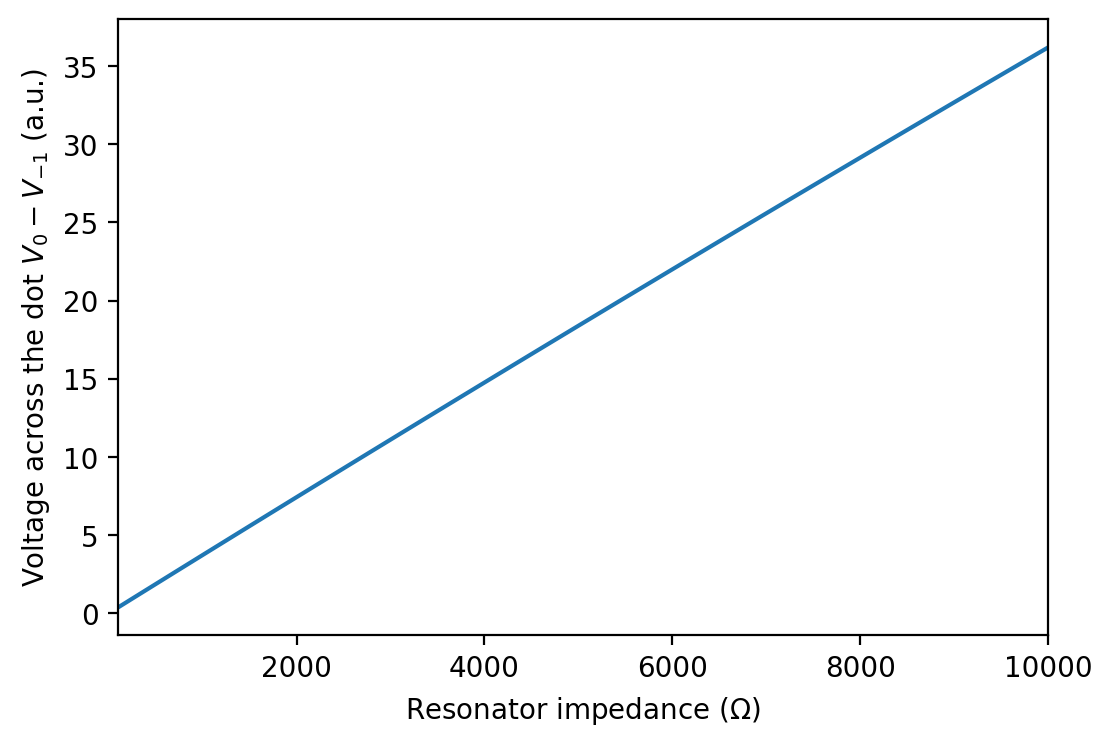

In [122]:
dx_um=25
total_length_mm=2
f0_diff = 6.1e9

C_dot_fF = 0.02
impedances = np.linspace(10 ** 2, 10 ** 4)
inductances = impedances / (2 * np.pi * f0_diff)
capacitances = 1 / (impedances * 2 * np.pi * f0_diff) - 2 * C_dot_fF * 1e-15

do_plot = False
deltaV = np.zeros((len(impedances), 6))
eigenfreqs = np.zeros((len(impedances), 6))

fig = plt.figure(figsize=(6.,4.))

m = 0
for L_total_nH, C_total_fF in zip(inductances * 1e9, capacitances * 1e15):
    evecs_sorted, ev_sorted, dV = make_network(dx_um=dx_um, total_length_mm=total_length_mm, C_dot_fF=C_dot_fF, 
                                                L_total_nH=L_total_nH, C_total_fF=C_total_fF, plot=False, return_all=True)
    
    deltaV[m, :] = np.abs(np.array(dV))
    eigenfreqs[m, :] = np.sqrt(ev_sorted[:6]) / (2 * np.pi * 1e9)

    m += 1

plt.plot(impedances, deltaV[:, 0] / 1e13)
plt.xlabel("Resonator impedance ($\Omega$)")
plt.ylabel("Voltage across the dot $V_0 - V_{-1}$ (a.u.)")
plt.xlim(impedances.min(), impedances.max())

The voltage across the dot scales linearly with the impedance because the total inductance $L \propto Z$ (when keeping $f_0$ constant) and $V_{n+1} - V_n = L \, dI_n / dt$. Note that this is not true for the zero-point fluctuations across the dot, which should scale with $\sqrt{Z}$ when the resonance frequency is kept fixed.

### Inspect mode profiles for a single parameter set

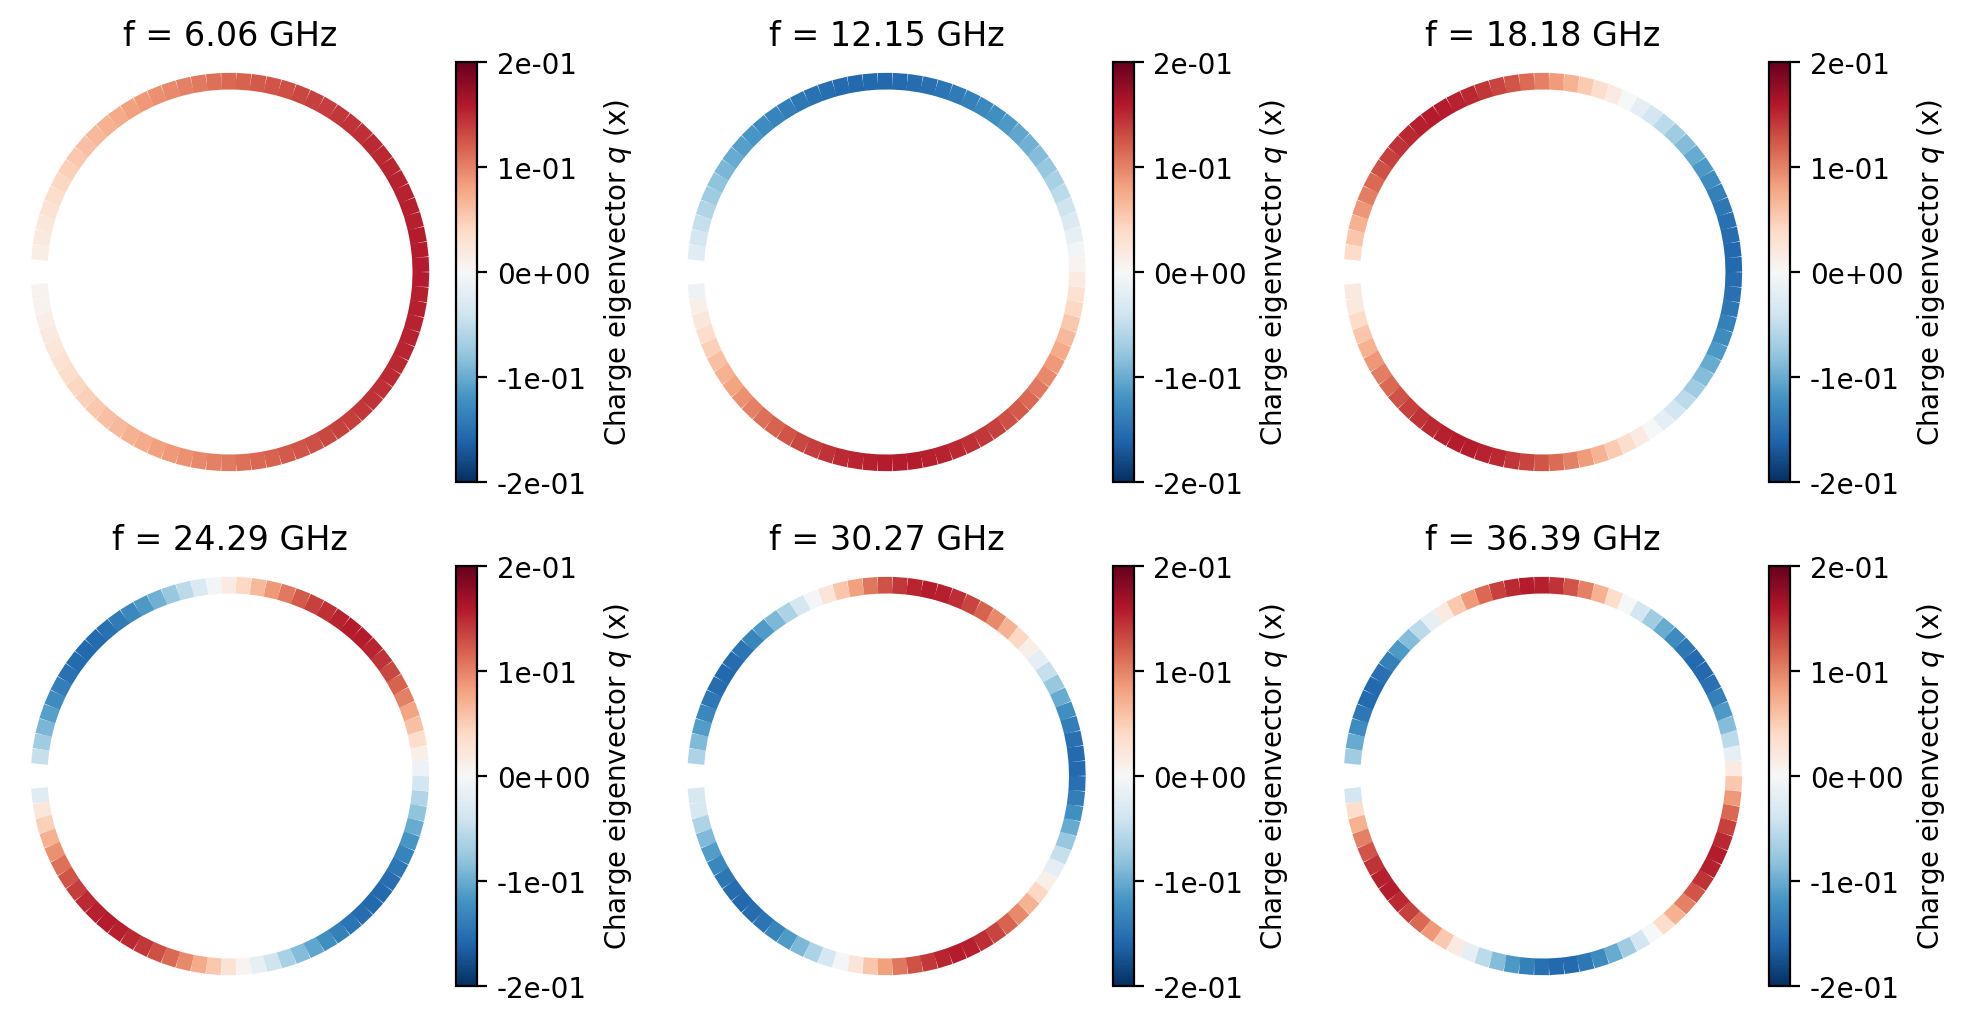

In [110]:
dx_um=25
total_length_mm=2
C_dot_fF = 0.02
L_total_nH= 200
C_total_fF= 33

evecs_sorted, ev_sorted, dV = make_network(dx_um=dx_um, total_length_mm=total_length_mm, C_dot_fF=C_dot_fF, 
                                            L_total_nH=L_total_nH, C_total_fF=C_total_fF, plot=False, return_all=True)

plot_mode_profile(evecs_sorted.T, ev_sorted, colorbar_label=r"Charge eigenvector $q$ (x)", clim=(-0.2, 0.2), savepath=None)

### Scikit RF model

Here we'll construct a sci-kit RF network to verify the behavior observed in the numerical EOM approach from the previous section. This network also contains input and output capacitors to probe the resonance.
We'll use `plot_s_db` to extract the transmission from port 1 to port 2. 

In [70]:
def make_scikit_network(L_total_nH, C_total_fF, C_dot_fF, fmin=1e9, fmax=15e9, plot=True, return_all=False):
    """Make the periodic transmission line resonator with a break in scikit-rf

    Args:
        L_total_nH (float): Total resonator inductance in nanohenries
        C_total_fF (float): Total resonator capacitance in femtofarads
        C_dot_fF (float): Dot capacitance in femtofarads
        fmin (float, optional): lower range of the frequency axis. Defaults to 1e9.
        fmax (float, optional): upper range of the frequency axis. Defaults to 15e9.
        plot (bool, optional): plot the results. Defaults to True.
        return_all (bool, optional): Defaults to False.

    Returns:
        ArrayLike: S21 scattering parameters (10,000 points)
    """
    Z_0 = 50
    Z_res = np.sqrt(L_total_nH*1e-9 / (C_total_fF * 1e-15))
    C_dot = C_dot_fF * 1e-15

    # The total length of the ring is 2 l1 + l2
    l1 = 2e-3
    l2 = 5e-3

    # The necessary frequency description
    freq = rf.Frequency(start=fmin, stop=fmax, unit='Hz', npoints=10000)

    port1 = rf.Circuit.Port(freq, 'port1', z0=Z_0)
    port2 = rf.Circuit.Port(freq, 'port2', z0=Z_0)
    gnd = rf.Circuit.Ground(frequency=freq, name='ground')

    # piece of transmission line and series impedance
    tline_media = cpw.CPW(freq, z0_override=Z_res, ep_r=11, rho=0)
    trans_line_a = tline_media.line(l1, unit='m', name='trans_line_a')
    trans_line_b1 = tline_media.line(l2, unit='m', name='trans_line_b1')
    trans_line_c = tline_media.line(l1, unit='m', name='trans_line_c')

    C_c1 = tline_media.capacitor(2e-15, name='C_in')
    C_c2 = tline_media.capacitor(2e-15, name='C_out')
    C_dot = tline_media.capacitor(C_dot, name='Cdot')

    cnx = [[(port1, 0), (C_c1, 0)],
        [(C_c1, 1), (trans_line_a, 0), (trans_line_b1, 0)],
        [(trans_line_a, 1), (C_dot, 0)],
        [(C_dot, 1), (trans_line_c, 1)], 
        [(trans_line_c, 0), (C_c2, 0), (trans_line_b1, 1)],
        [(port2, 0), (C_c2, 1)]]

    cir = rf.Circuit(cnx)
    ntw = cir.network

    if plot:
        plt.figure(figsize=(5.,3.))
        ntw.plot_s_db(m=0, n=0, lw=2, logx=False)
        ntw.plot_s_db(m=1, n=0, lw=2, logx=False)

    if return_all:
        # Return the element (0, 1) from the scattering matrix for the given frequencies
        return ntw.s[np.logical_and(ntw.f >= fmin, ntw.f <= fmax), 0, 1]

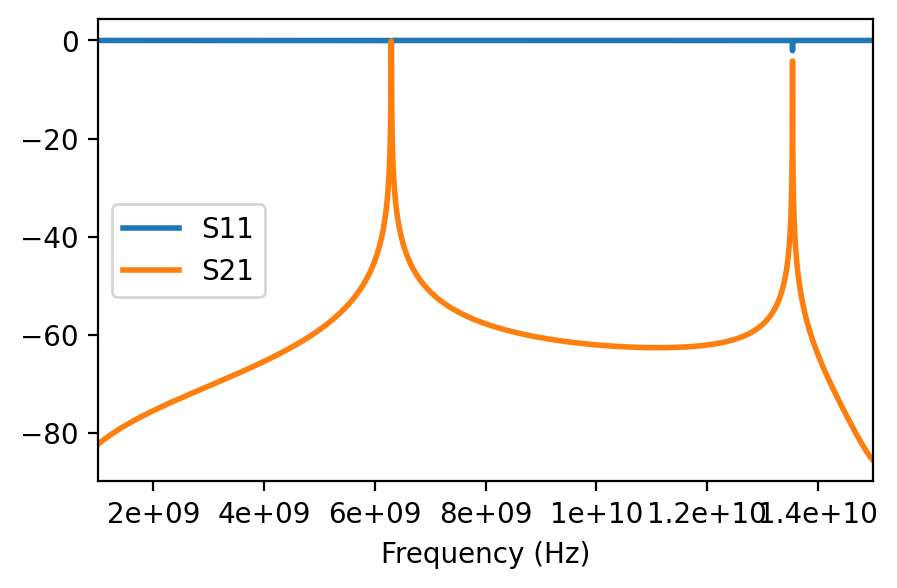

In [71]:
make_scikit_network(L_total_nH=200, C_total_fF=33, C_dot_fF=0.02, fmin=1e9, fmax=15e9, plot=True, return_all=False)

In the cell below, we'll sweep $C_\mathrm{dot}$ and show that the resulting behavior is similar to the EOM method.

In [84]:
dot_capacitances_fF = np.logspace(-2, 1, 101)
L_total_nH= 200
C_total_fF= 33

s21s = np.zeros((len(dot_capacitances_fF), 10000))
  
for m, C_dot_fF in enumerate(dot_capacitances_fF):  
    s21 = make_scikit_network(L_total_nH=L_total_nH, C_total_fF=C_total_fF, C_dot_fF=C_dot_fF, fmin=1e9, fmax=30e9, plot=False, return_all=True)
    s21s[m, :] = 20 * np.log10(np.abs(s21))

Text(0, 0.5, 'Frequency (GHz)')

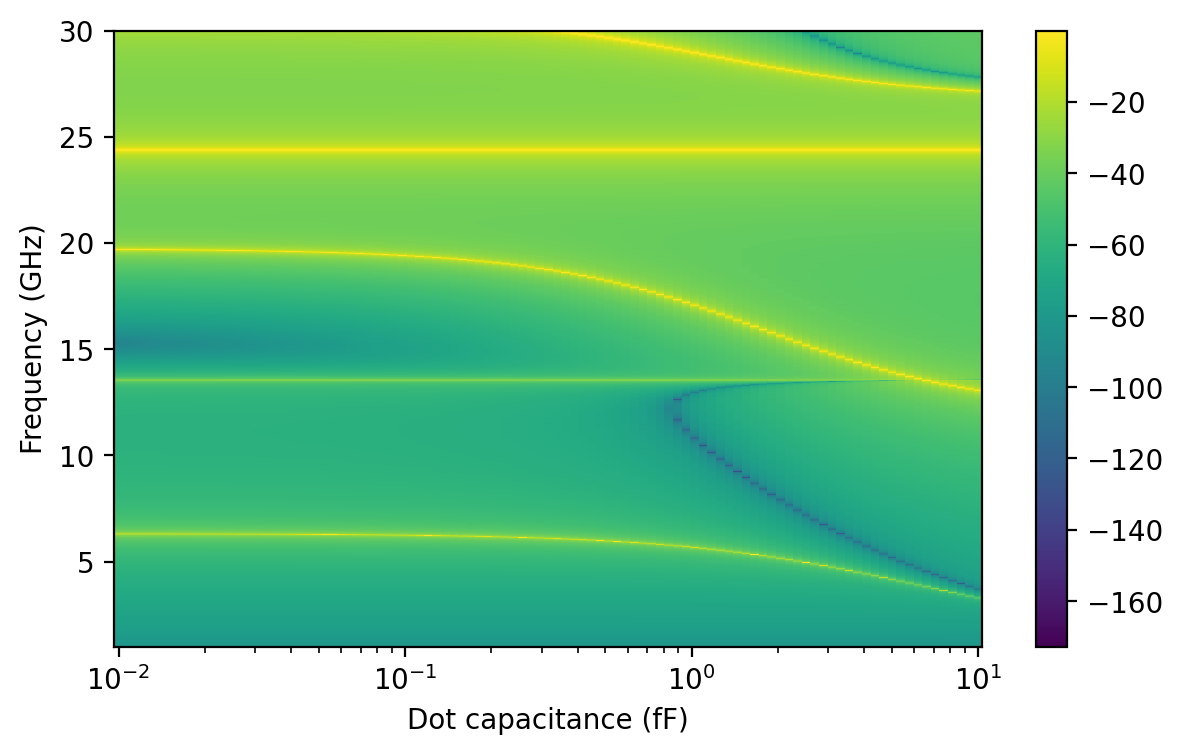

In [85]:
fig = plt.figure(figsize=(7.,4.))
plt.pcolormesh(dot_capacitances_fF, np.linspace(1, 30, 10000), s21s.T)
plt.colorbar()
plt.xscale('log')
plt.xlabel("Dot capacitance (fF)")
plt.ylabel("Frequency (GHz)")

Let's also check that the network we just constructed makes sense

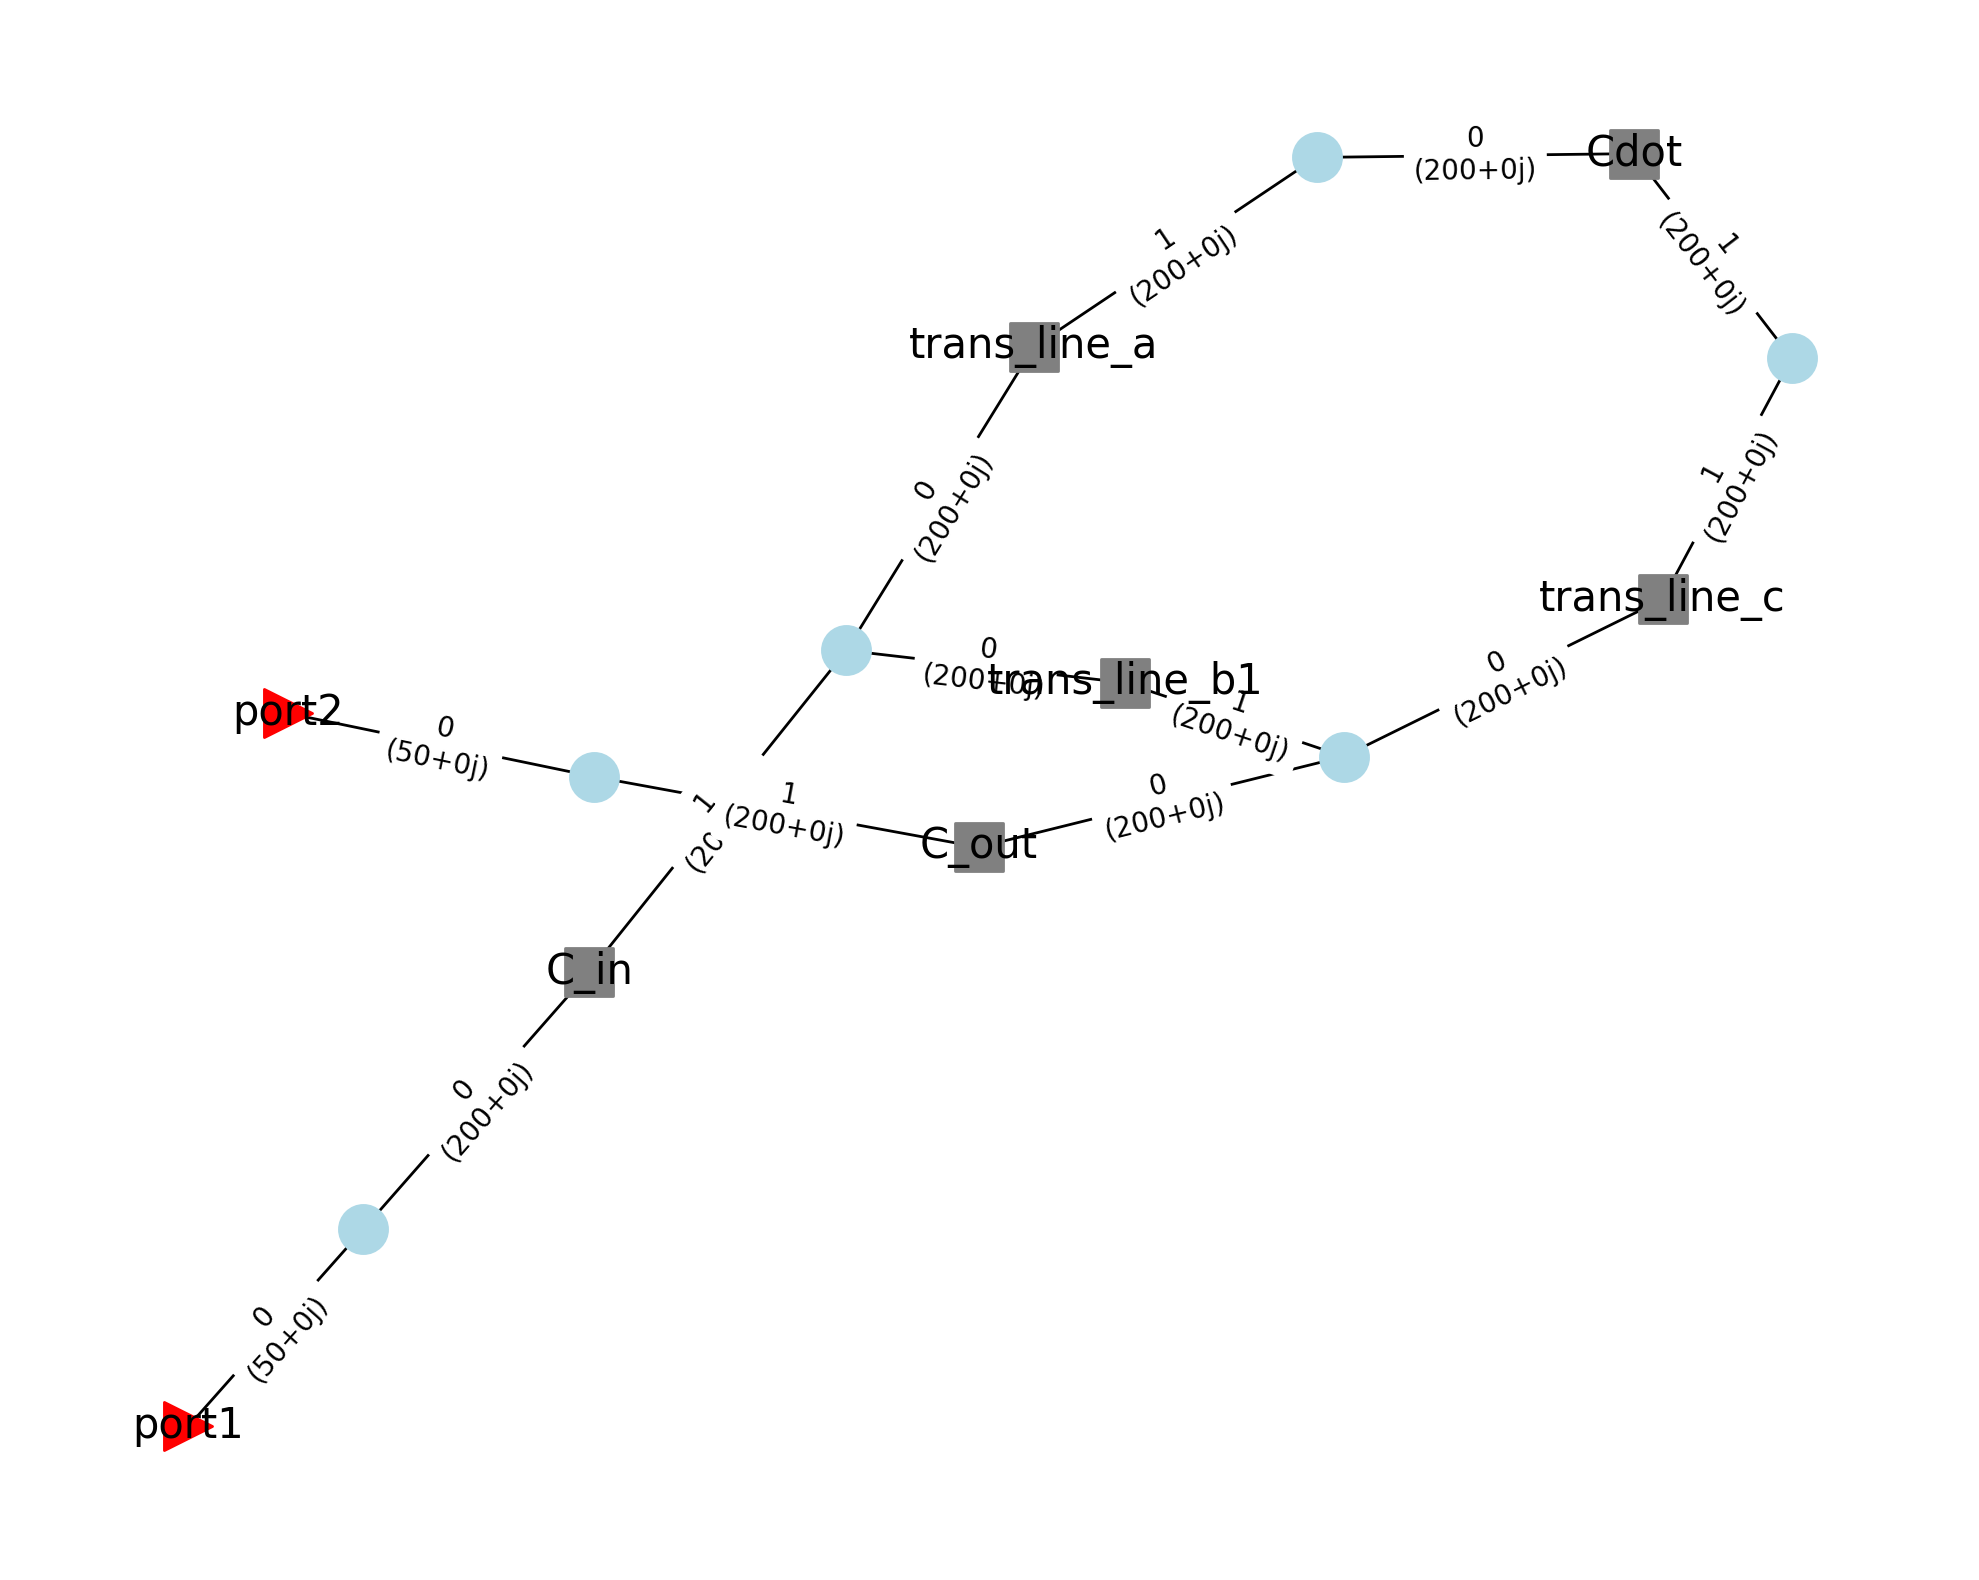

In [11]:
cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_labels=True, edge_fontsize=10)

### Work in progress

In [12]:
@widgets.interact(dx_um=(1, 100, 1), total_length_mm=(0.5, 10, 0.05), C_dot_fF=(0.0, 5.0, 0.01), C_g_fF=(0.0, 5.0, 0.01), L_total_nH=(1, 500, 1), C_total_fF=(1, 200, 1))
def update(dx_um=25, total_length_mm=2, C_dot_fF=0.0, C_g_fF=0.1, L_total_nH=100, C_total_fF=33):
    dx = dx_um * 1e-6
    unit_cells = int(total_length_mm / (dx_um / 1e3))

    if unit_cells % 2:
        unit_cells += 1

    assert not(unit_cells % 2)
    L_l = L_total_nH * 1e-9 / unit_cells
    C_l = C_total_fF * 1e-15 / unit_cells
    C_dot = C_dot_fF * 1e-15
    # C_g = C_g_fF * 1e-15
    C_g = C_l

    print(C_g/C_l)

    K = 1 / C_l * ( np.diag(-1 * np.ones(unit_cells-1), k=-1) + np.diag(2 * np.ones(unit_cells), k=0) + np.diag(-1 * np.ones(unit_cells-1), k=1) )
    M = L_l * np.diag(np.ones(unit_cells), k=0)

    D = C_g * (C_g + 2 * C_dot)
    alpha = (C_g + C_dot) / D
    beta = C_dot / D

    idx_minus1 = unit_cells // 2 - 1
    idx_plus1 = unit_cells // 2 + 1

    K[idx_minus1:idx_plus1, idx_minus1:idx_plus1] = np.array([[alpha, beta], 
                                                              [beta, alpha]])

    # Periodic boundary conditions
    K[0, -1] = -1 / C_l
    K[-1, 0] = -1 / C_l

    ev, evecs = np.linalg.eig(np.linalg.inv(M) @ K)
    order = np.argsort(ev)

    ev_sorted = ev[order]
    evecs_sorted = evecs[:, order]

    fig, ax = plt.subplots(1, 2, figsize=(10.,3.))

    for k in range(6):
        # Shifted eigenvector
        evec_shifted = np.roll(evecs_sorted[:, k], unit_cells // 2)
        x = np.arange(unit_cells) * dx * 1e3
        ax[0].plot(x, evec_shifted)

    ax[0].set_xlim(-0.05, np.max(x)+0.05)
    ax[0].set_xlabel("Position along the transmission line (mm)")
    ax[0].set_ylabel(r"Charge eigenvector $q_n$ (a.u.)")

    for k in range(20):
        ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o')

    ax[1].set_xlabel("Mode number")
    ax[1].set_ylabel("Mode frequency (GHz)")
    ax[1].set_ylim(0, 30)

    # Convert to voltage eigenvector:
    # q = C V
    Cmat = np.diag(C_l * np.ones(unit_cells))
    Cmat[idx_minus1:idx_plus1, idx_minus1:idx_plus1] = np.array([[C_l + C_dot, -C_dot], 
                                                                 [-C_dot, C_l + C_dot]])
    evecs_voltage = [np.linalg.inv(Cmat) @ evec_charge for evec_charge in evecs_sorted.T]

    # plot_mode_profile(evecs_sorted.T, ev_sorted, colorbar_label="Charge eigenvector $q$ (x)")
    # plot_mode_profile(evecs_voltage, ev_sorted, colorbar_label="Voltage eigenvector $\dot{\phi}$ (x)")

    plt.figure()
    plt.imshow(K)
    plt.colorbar()

interactive(children=(IntSlider(value=25, description='dx_um', min=1), FloatSlider(value=2.0, description='tot…

## EOM solution in the $\phi$ basis

In [30]:
@widgets.interact(dx_um=(1, 100, 1), total_length_mm=(0.5, 10, 0.05), C_dot_fF=(0.0, 100, 0.1), L_total_nH=(1, 500, 1), C_total_fF=(1, 200, 1))
def update(dx_um=25, total_length_mm=2, C_dot_fF=0.1, L_total_nH=100, C_total_fF=33):
    dx = dx_um * 1e-6
    unit_cells = int(total_length_mm / (dx_um / 1e3))

    L_l = 1e-9 * L_total_nH / unit_cells
    C_l = 1e-15 * C_total_fF / unit_cells
    C_dot = C_dot_fF * 1e-15

    K = np.diag(-1/L_l * np.ones(unit_cells-1), k=-1) + np.diag(2/L_l * np.ones(unit_cells), k=0) + np.diag(-1/L_l * np.ones(unit_cells-1), k=1)
    M = np.diag(C_l * np.ones(unit_cells), k=0)

    idx_minus1 = unit_cells // 2 - 1
    idx_plus1 = unit_cells // 2 + 1

    M[idx_minus1:idx_plus1, idx_minus1:idx_plus1] = np.array([[C_l + C_dot, -C_dot], 
                                                                [-C_dot, C_l + C_dot]])

    K[idx_minus1:idx_plus1, idx_minus1-1:idx_plus1+1] = np.array([[0, 1 / L_l, -1 / L_l, 0], 
                                                                [0, -1 / L_l, 1 / L_l, 0]])

    # Periodic boundary conditions
    K[0, -1] = -1 / L_l
    K[-1, 0] = -1 / L_l

    ev, evecs = np.linalg.eig(np.linalg.inv(M) @ K)
    order = np.argsort(ev)

    ev_sorted = ev[order]
    evecs_sorted = evecs[:, order]

    fig, ax = plt.subplots(1, 3, figsize=(14.,3.))

    x = np.arange(unit_cells) * dx * 1e3
    for k in range(4):
        ax[0].plot(x, np.roll(evecs_sorted[:, k], unit_cells // 2))
        # ax[0].plot(x, evecs_sorted[:, k])

    ax[0].set_xlim(-0.05, np.max(x)+0.05)
    ax[0].set_xlabel("Position along the transmission line (mm)")
    ax[0].set_ylabel(r"Phase eigenvector $\phi_n$ (a.u.)")
    
    evecs_voltage = np.zeros(np.shape(evecs_sorted))
    for k in range(6):
        phi_n = evecs_sorted[:, k] #np.roll(evecs_sorted[:, k], unit_cells // 2)
        
        # Use the telegrapher equations to integrate phi and get voltage profile
        V_n = np.zeros(len(phi_n))
        # Start integrating from the center (one cannot start near the tips due to the discontinuity)
        # Integrate from center toward the right tip
        for n in range(len(phi_n) // 2 - 1):
            V_n[n+1] = V_n[n] - dx * np.sqrt(ev_sorted[k]) * phi_n[n]
        
        # Integrate from center toward the left tip
        for n in range(len(phi_n) // 2):
            V_n[-n-1] = V_n[-n] + dx * np.sqrt(ev_sorted[k]) * phi_n[-n]
        
        evecs_voltage[:, k] = V_n
        # ax[1].plot(x, phi_n)
        ax[1].plot(x, np.roll(V_n, unit_cells // 2))
    ax[1].set_ylabel(r"Voltage mode profile $V_n$")
    ax[1].set_xlim(-0.05, np.max(x)+0.05)

    for k in range(20):
        ax[2].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o')

    ax[2].set_xlabel("Mode number")
    ax[2].set_ylabel("Mode frequency (GHz)")
    ax[2].set_ylim(0, 40)
    
    fig.tight_layout()

    # fig, ax = plt.subplots(1, 2, figsize=(10.,3.))
    # ax[0].imshow(M, cmap=plt.cm.RdBu_r, vmin=-M.max(), vmax=M.max())
    # ax[1].imshow(K, cmap=plt.cm.RdBu_r, vmin=-K.max(), vmax=K.max())

    plot_mode_profile(evecs_voltage.T, ev_sorted, colorbar_label=r"Voltage eigenvector $V (x)$")

interactive(children=(IntSlider(value=25, description='dx_um', min=1), FloatSlider(value=2.0, description='tot…

# Tuning fork resonator -- a.k.a. Coupled Stripline Resonator

In [53]:
def unfold(eigenvector):
    return eigenvector[::2], eigenvector[1::2]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


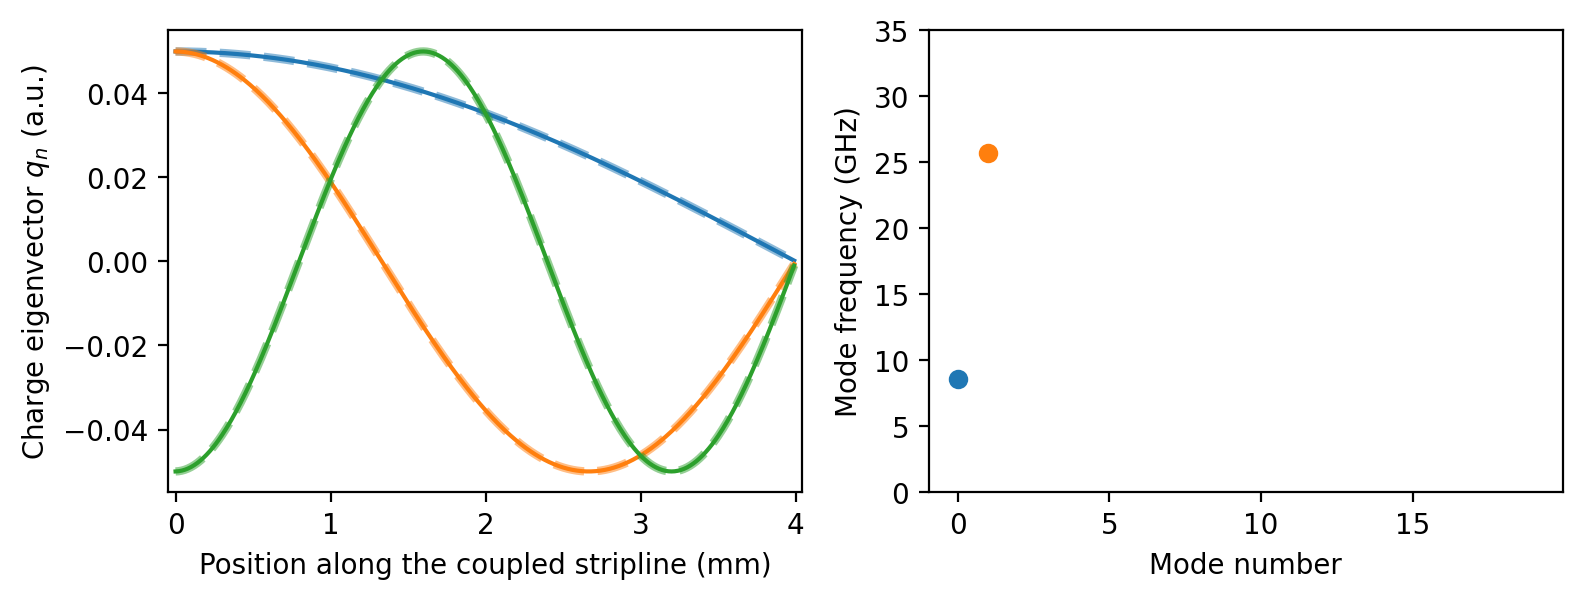

In [113]:
# @widgets.interact(dx_um=(1, 100, 1), total_length_mm=(0.5, 10, 0.05), L_total_nH=(1, 500, 1), C_total_fF=(1, 200, 1), shunt_cap_fraction=(0, 4, 0.01))
# def update(dx_um=25, total_length_mm=2, L_total_nH=100, C_total_fF=33, shunt_cap_fraction=0.01):

dx_um=10
total_length_mm=8

L11_nH_m=515
L12_nH_m=199
C11_pF_m=103
C12_pF_m=166

dx = dx_um * 1e-6
unit_cells = int(total_length_mm / (dx_um / 1e3))

L11_dx = 1e-9 * L11_nH_m * dx
L12_dx = 1e-9 * L12_nH_m * dx
C11_dx = 1e-12 * C11_pF_m * dx
C12_dx = 1e-12 * C12_pF_m * dx

Ctot_dx = C11_dx + 2 * C12_dx
cap_cpl = C12_dx / C11_dx

M = -np.diag(Ctot_dx * np.ones(unit_cells), k=0)

third_off_diag = np.zeros(unit_cells-3)
third_off_diag[::2] = cap_cpl / L11_dx

first_off_diag = np.zeros(unit_cells-1)
first_off_diag[::2] = -2 * cap_cpl / L11_dx + 1 / L12_dx
first_off_diag[1::2] = cap_cpl / L11_dx

K = np.diag((-2 / L11_dx * (1 + cap_cpl) - 1 / L12_dx) * np.ones(unit_cells), k=0) \
    + np.diag((1 + cap_cpl) / L11_dx * np.ones(unit_cells-2), k=2) + np.diag((1 + cap_cpl) / L11_dx * np.ones(unit_cells-2), k=-2) \
        + np.diag(first_off_diag, k=1) + np.diag(first_off_diag, k=-1) \
        + np.diag(third_off_diag, k=3) + np.diag(third_off_diag, k=-3)

K[0, 0] = -1 / L11_dx * (1 + cap_cpl) - 1 / L12_dx
K[0, 1] = -cap_cpl / L11_dx + 1 / L12_dx

K[1, 0] = -cap_cpl / L11_dx + 1 / L12_dx
K[1, 1] = -1 / L11_dx * (1 + cap_cpl) - 1 / L12_dx

ev, evecs = np.linalg.eig(np.linalg.inv(M) @ K)
order = np.argsort(ev)

ev_sorted = ev[order]
evecs_sorted = evecs[:, order]

fig, ax = plt.subplots(1, 2, figsize=(9.,3.))

x = np.arange(unit_cells // 2) * dx * 1e3
colors = ['tab:blue', 'tab:orange', 'tab:green']
for k in range(3):
    ax[0].plot(x, unfold(evecs_sorted[:, k])[0], '-', color=colors[k])
    ax[0].plot(x, unfold(evecs_sorted[:, k])[1], '--', color=colors[k], lw=3, alpha=0.5)

ax[0].set_xlim(-0.05, np.max(x)+0.05)
ax[0].set_xlabel("Position along the coupled stripline (mm)")
ax[0].set_ylabel(r"Charge eigenvector $q_n$ (a.u.)")

for k in range(20):
    if k <= 4:
        ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o')
    else:
        ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o', color='lightgray')

# Dispersion with shunt capacitance:
# m = np.arange(1, 8)
# f_with_shunt = m / (2 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15)) * np.sqrt(1 / (1 + (m * np.pi / unit_cells) ** 2 * C_s / C_l))

# ax[1].plot(np.arange(7), np.arange(1, 8) / (2 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15)), 's', mfc='none', mec='k', label="Theory without shunt")
# ax[1].plot(np.arange(7), f_with_shunt, 'd', mfc='none', mec='k', label="Theory with shunt")

ax[1].set_xlabel("Mode number")
ax[1].set_ylabel("Mode frequency (GHz)")
ax[1].set_ylim(0, 35)
plt.legend(loc=4, frameon=False)

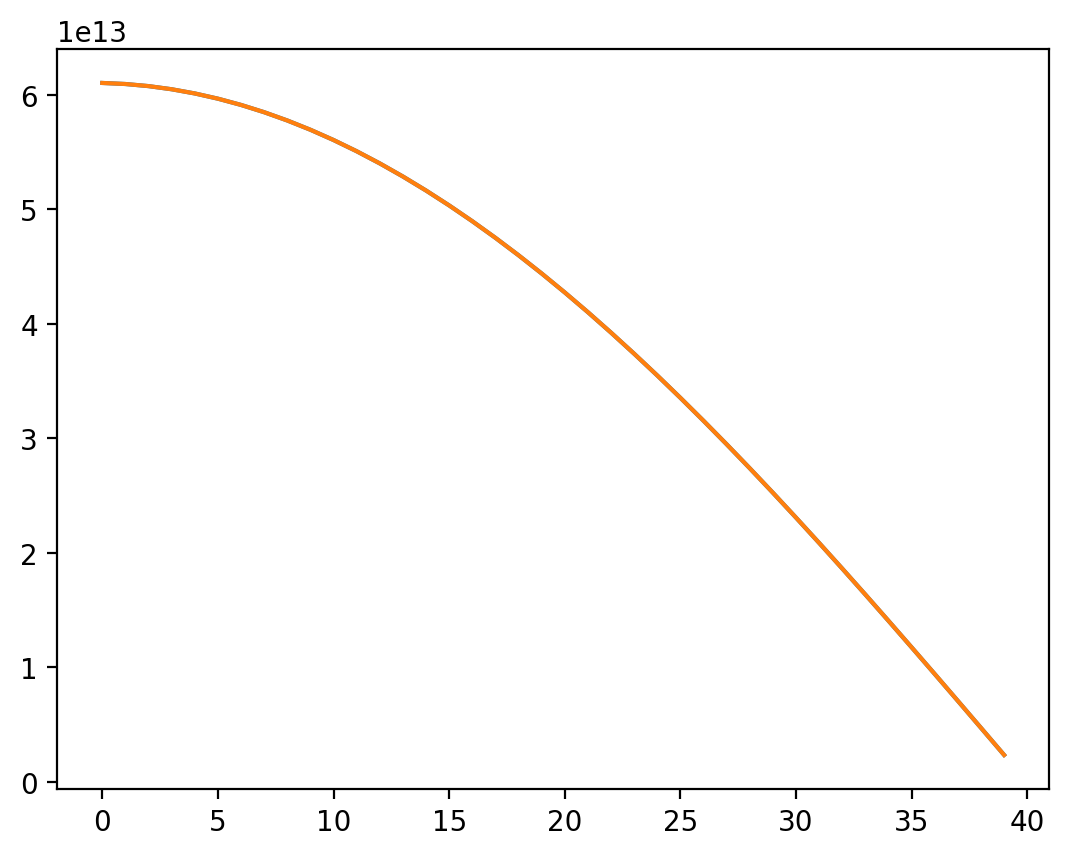

In [102]:
qn, qk = unfold(evecs_sorted[:, 0])

Vn = 1 / Ctot_dx * ((1 + cap_cpl) * qn + cap_cpl * qk)
Vk = 1 / Ctot_dx * ((1 + cap_cpl) * qk + cap_cpl * qn)

plt.plot(Vn)
plt.plot(Vk)